# Machine Learning Techniques to Reduce the Cost Function

## Using a flight prices dataset

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 8)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import pylab
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

In [2]:
start = datetime.now()

# Data Cleaning

In [3]:
df = pd.read_excel('dataset', sheet_name='Sheet1')


In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,...,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,...,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,...,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,...,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,...,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,...,4h 45m,1 stop,No info,13302


In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
df.dropna(inplace = True) #dropnull values

In [7]:
def calculate_total_mins(column):
    x_seps = column.split(' ')
    total_mins = 0
    for x_sep in x_seps:
        if 'h' in x_sep: 
            total_mins = total_mins+float(x_sep.replace('h',''))*60
        elif 'm' in x_sep:
            total_mins = total_mins+float(x_sep.replace('m',''))
    return total_mins

In [8]:
df['flight_time'] = df['Duration'].apply(lambda x: calculate_total_mins(x))
df['flight_date'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').astype(int)

In [9]:
df['stops'] = df['Total_Stops'].apply(lambda x: int(x[0].replace('n','0')))

In [10]:
other_airlines = (df['Airline'].value_counts()
                 .reset_index().query('abs(Airline) < {}'
                .format(20))['index'].to_list())

df['Airline'] = df['Airline'].apply(lambda x: 'Other' if x in other_airlines else x)

In [11]:
df.groupby(['Additional_Info'])['Price'].agg(['mean','count']).reset_index()

,Additional_Info,mean,count
0,1 Long layover,22109.631579,19
1,1 Short layover,26743.000000,1
2,2 Long layover,26480.000000,1
3,Business class,56811.250000,4
4,Change airports,16800.714286,7
5,In-flight meal not included,9471.834511,1982
6,No Info,8044.666667,3
7,No check-in baggage included,3645.156250,320
8,No info,9141.519295,8344
9,Red-eye flight,10873.000000,1


In [12]:
# create seperate columns for certain Additional_Info values
df['business_class'] = df['Additional_Info'].apply(lambda x: 1 if 'Business' in x else 0)
df['no_baggage_check_in'] = df['Additional_Info'].apply(lambda x: 1 if 'No check-in baggage' in x else 0)
df['no_meal'] = df['Additional_Info'].apply(lambda x: 1 if 'In-flight meal not included' in x else 0)
df['long_layover'] = df['Additional_Info'].apply(lambda x: 1 if 'layover' in x else 0)

In [13]:
df.drop(['Additional_Info','Date_of_Journey','Dep_Time','Arrival_Time',
        'Total_Stops','Route','Duration'],1,inplace=True)

# dep_time and dep_arrival both used for duration
# total_stops and route both used for stops
# additional_info largely unhelpful

In [14]:
df.columns = [x.lower() for x in list(df.columns)]
print(df.shape)
df.head()
# data_cleaning finished

(10682, 11)


,airline,source,destination,price,...,business_class,no_baggage_check_in,no_meal,long_layover
0,IndiGo,Banglore,New Delhi,3897,...,0,0,0,0
1,Air India,Kolkata,Banglore,7662,...,0,0,0,0
2,Jet Airways,Delhi,Cochin,13882,...,0,0,0,0
3,IndiGo,Kolkata,Banglore,6218,...,0,0,0,0
4,IndiGo,Banglore,New Delhi,13302,...,0,0,0,0


In [15]:
one_hot_encode_cols = df.dtypes[df.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

df[one_hot_encode_cols].head().T

,0,1,2,3,4
airline,IndiGo,Air India,Jet Airways,IndiGo,IndiGo
source,Banglore,Kolkata,Delhi,Kolkata,Banglore
destination,New Delhi,Banglore,Cochin,Banglore,New Delhi


In [16]:
df = pd.get_dummies(df, columns=one_hot_encode_cols, drop_first=True)

In [17]:
df.head()

,price,flight_time,flight_date,stops,...,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_New Delhi
0,3897,170.0,1553385600000000000,0,...,0,0,0,1
1,7662,445.0,1556668800000000000,2,...,0,0,0,0
2,13882,1140.0,1560038400000000000,2,...,0,0,0,0
3,6218,325.0,1557619200000000000,1,...,0,0,0,0
4,13302,285.0,1551398400000000000,1,...,0,0,0,1


# Feature Engineering

In [18]:
before = df.copy()

Number of rows before: 10682
Number of rows after: 10533


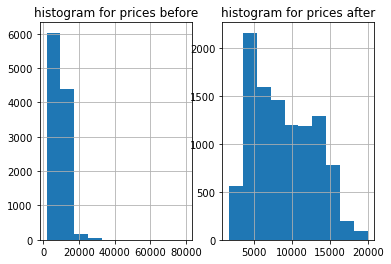

In [19]:
print("Number of rows before:", before.shape[0])
df = df.loc[(df['price'] <= 20000) & (df['flight_time']>60)]
print("Number of rows after:", df.shape[0])

fig, axes = plt.subplots(1, 2)
axes[0].set_title('histogram for prices before')
axes[1].set_title('histogram for prices after')

before['price'].hist(ax=axes[0])
df['price'].hist(ax=axes[1])
None

#### Dealing with Skew Variables


In [20]:
df.head()

,price,flight_time,flight_date,stops,...,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_New Delhi
0,3897,170.0,1553385600000000000,0,...,0,0,0,1
1,7662,445.0,1556668800000000000,2,...,0,0,0,0
2,13882,1140.0,1560038400000000000,2,...,0,0,0,0
3,6218,325.0,1557619200000000000,1,...,0,0,0,0
4,13302,285.0,1551398400000000000,1,...,0,0,0,1


In [21]:
mask = df.dtypes == np.float
float_cols = df.columns[mask]

skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = df[float_cols].skew()

skew_cols = (skew_vals.sort_values(ascending=False)
             .to_frame().rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
flight_time,0.856164


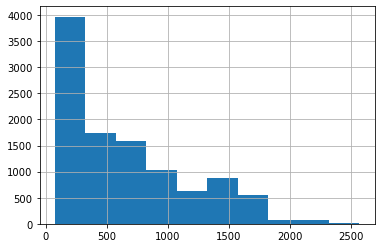

In [22]:
df['flight_time'].hist()

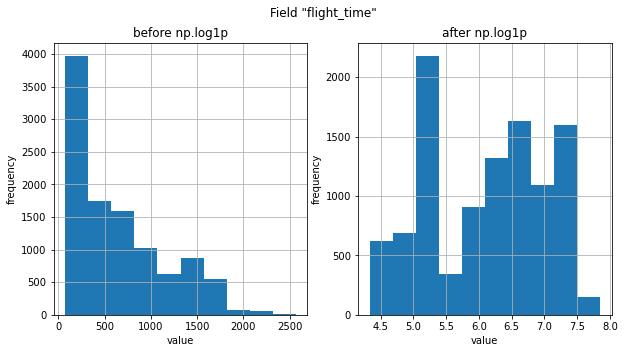

In [23]:
# Let's look at what happens to one of these features, when we apply np.log1p visually.

# Choose a field
field = "flight_time"

# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
df[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
df[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));

In [24]:
# convert all skewed columns to log1p columns
for col in skew_cols.index.values:
    if col == "price":
        continue
    df[col] = df[col].apply(np.log1p)

# EDA

In [25]:
df.describe()

,price,flight_time,flight_date,stops,...,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_New Delhi
count,10533.000000,10533.000000,1.053300e+04,10533.000000,...,10533.000000,10533.000000,10533.000000,10533.000000
mean,8831.720497,6.097555,1.557074e+18,0.818096,...,0.120099,0.065034,0.036172,0.079180
std,3974.959829,0.906567,3.095518e+15,0.674918,...,0.325092,0.246597,0.186727,0.270032
min,1759.000000,4.330733,1.551398e+18,0.000000,...,0.000000,0.000000,0.000000,0.000000
25%,5228.000000,5.141664,1.554077e+18,0.000000,...,0.000000,0.000000,0.000000,0.000000
50%,8285.000000,6.246107,1.557878e+18,1.000000,...,0.000000,0.000000,0.000000,0.000000
75%,12242.000000,6.836259,1.559779e+18,1.000000,...,0.000000,0.000000,0.000000,0.000000
max,19907.000000,7.850104,1.561594e+18,4.000000,...,1.000000,1.000000,1.000000,1.000000


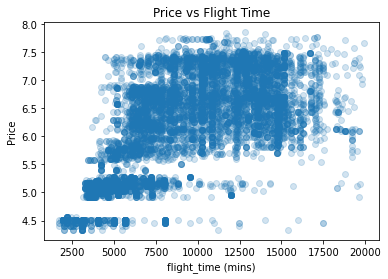

In [26]:
# A simple scatter plot with Matplotlib
ax = plt.axes()

ax.scatter(df['price'],df['flight_time'],alpha=0.2)

# Label the axes
ax.set(xlabel='flight_time (mins)',
       ylabel='Price',
       title='Price vs Flight Time');
### END SOLUTION

In [27]:
# sns.set_context('talk')
# sns.pairplot(df);


### Determining Normality of Target Variable


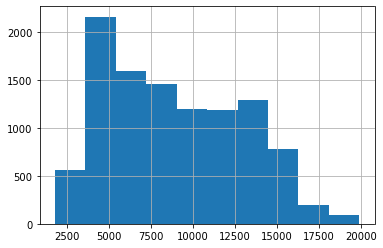

In [28]:
df['price'].hist()

Data does not look normally distrubuted due to the right tail. We can verify this statistically

In [29]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

The p-value we have is very low, therefore our target variable is not normally distrubuted.

NormaltestResult(statistic=723.0778341485475, pvalue=9.674829526740758e-158)

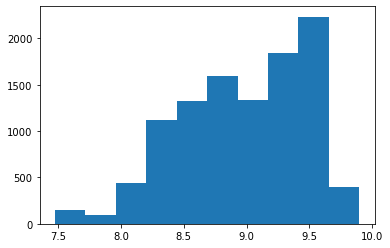

In [30]:
log_price = np.log(df['price'])
plt.hist(log_price)
normaltest(log_price)

NormaltestResult(statistic=2784.1765527540415, pvalue=0.0)

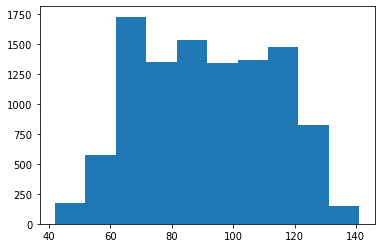

In [31]:
sqrt_price = np.sqrt(df['price'])
plt.hist(sqrt_price)
normaltest(sqrt_price)

NormaltestResult(statistic=2479.413141641205, pvalue=0.0)

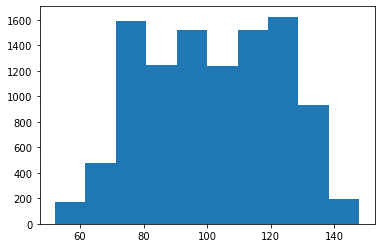

In [32]:
from scipy.stats import boxcox
bc_result = boxcox(df['price'])
bc_price = bc_result[0]
plt.hist(bc_price)
normaltest(bc_price)

In [33]:
#function to return plots for the feature
def normality(transform):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(transform)
    plt.subplot(1,2,2)
    stats.probplot(transform,plot=pylab)
    plt.show()
    print(normaltest(transform))

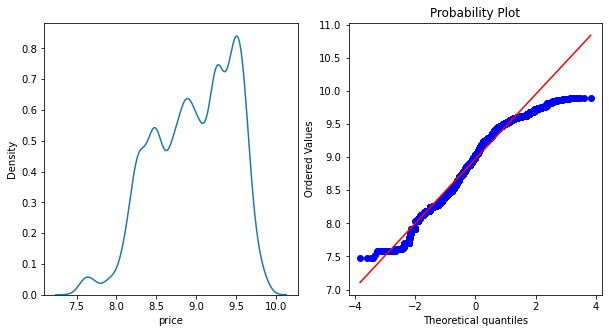

NormaltestResult(statistic=723.0778341485475, pvalue=9.674829526740758e-158)


In [34]:
normality(np.log(df['price']))


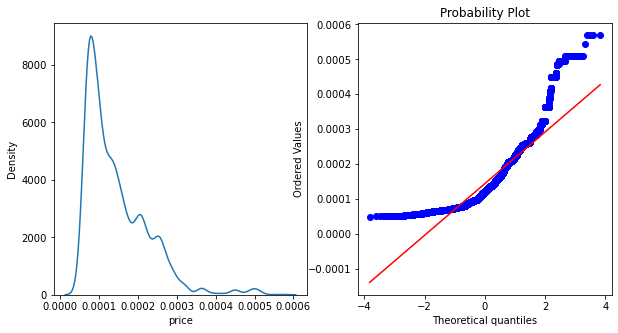

NormaltestResult(statistic=3213.837279353121, pvalue=0.0)


In [35]:
normality(1/df['price'])


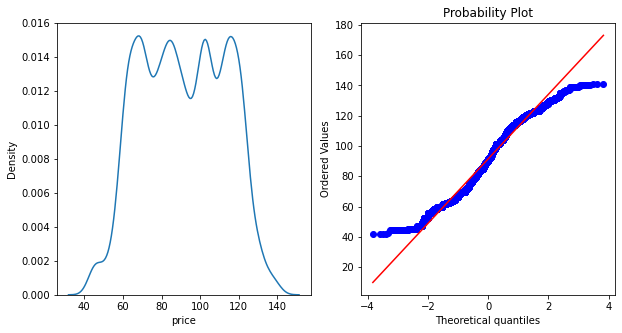

NormaltestResult(statistic=2784.1765527540415, pvalue=0.0)


In [36]:
normality(np.sqrt(df['price']))


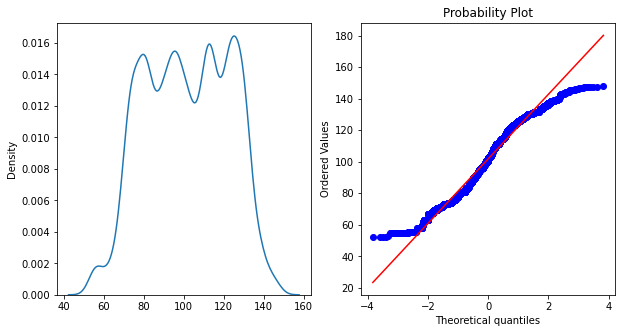

NormaltestResult(statistic=2479.413141641205, pvalue=0.0)


In [37]:
normality(stats.boxcox(df['price'])[0])


From this a log transformation makes the target variables marginally more normally distrubuted

In [38]:
before = df.copy()

In [39]:
df['price'] = np.sqrt(df['price'])

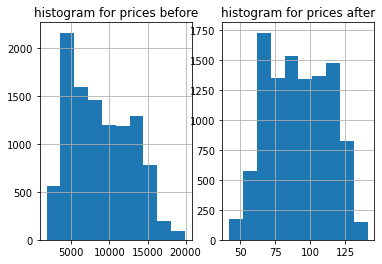

In [40]:

fig, axes = plt.subplots(1, 2)
axes[0].set_title('histogram for prices before')
axes[1].set_title('histogram for prices after')

before['price'].hist(ax=axes[0])
df['price'].hist(ax=axes[1])


## Testing Regression and CV


In [41]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict



In [42]:
target = "price"

X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(8426, 24) (8426,) (2107, 24) (2107,)


In [43]:
kf = KFold(shuffle=True, random_state=42, n_splits=3)

model_selection = []
model_cv_score = []
model_r2_score = []

models = [LinearRegression()]
for model in models:
    model.fit(X_train,y_train)
    model_pred = model.predict(X_test)

    cv_pred = cross_val_predict(model, X_train, y_train, cv=kf)
    cv_r2 = r2_score(y_train, cv_pred)

    r2 = r2_score(model_pred,y_test)

    model_selection.append(type(model).__name__),model_cv_score.append(cv_r2),model_r2_score.append(r2)
    print(type(model).__name__)
    print('CV r2 score:',cv_r2)
    print('r2 score:',r2)
    print()

df_r2_scores = pd.DataFrame([model_selection,model_cv_score,model_r2_score]).T
df_r2_scores.columns=['model','CV_score','r2_score']

LinearRegression
CV r2 score: -334.59469852198663
r2 score: 0.00466197161476134



In [44]:
df_r2_scores

,model,CV_score,r2_score
0,LinearRegression,-334.595,0.00466197


## Use Polynomial Features

In [45]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [46]:
pf = PolynomialFeatures(degree=2)
X_pf = pf.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, 
                                                    random_state=42)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(8426, 325) (8426,) (2107, 325) (2107,)


In [48]:
models = [LinearRegression()]
for model in models:
    model.fit(X_train,y_train)
    model_pred = model.predict(X_test)

    cv_pred = cross_val_predict(model, X_train, y_train, cv=kf)
    cv_r2 = r2_score(y_train, cv_pred)

    r2 = r2_score(model_pred,y_test)

    model_selection.append(type(model).__name__+' w/ Poly deg=2'),model_cv_score.append(cv_r2),model_r2_score.append(r2)
    print(type(model).__name__)
    print('CV r2 score:',cv_r2)
    print('r2 score:',r2)
    print()
    
df_r2_scores = pd.DataFrame([model_selection,model_cv_score,model_r2_score]).T
df_r2_scores.columns=['model','CV_score','r2_score']

LinearRegression
CV r2 score: 0.1236566074152532
r2 score: -9.241643438025319



In [49]:
df_r2_scores

,model,CV_score,r2_score
0,LinearRegression,-334.595,0.00466197
1,LinearRegression w/ Poly deg=2,0.123657,-9.24164


## Use Scalers

In [50]:
from sklearn.pipeline import Pipeline

In [51]:
s = StandardScaler()

In [52]:
models = [LinearRegression()]
for model in models:
    
    estimator = Pipeline([("scaler", s),
                      ("regression", model)])
    estimator.fit(X_train,y_train)
    model_pred = estimator.predict(X_test)

    cv_pred = cross_val_predict(estimator, X_train, y_train, cv=kf)
    cv_r2 = r2_score(y_train, cv_pred)

    r2 = r2_score(model_pred,y_test)

    model_selection.append(type(model).__name__+' w/ Poly deg=2, and scalers'),model_cv_score.append(cv_r2),model_r2_score.append(r2)
    print(type(model).__name__)
    print('CV r2 score:',cv_r2)
    print('r2 score:',r2)
    print()

df_r2_scores = pd.DataFrame([model_selection,model_cv_score,model_r2_score]).T
df_r2_scores.columns=['model','CV_score','r2_score']

LinearRegression
CV r2 score: -9.68798455462458e+22
r2 score: 0.7839644874068222



In [53]:
df_r2_scores

,model,CV_score,r2_score
0,LinearRegression,-334.595,0.00466197
1,LinearRegression w/ Poly deg=2,0.123657,-9.24164
2,"LinearRegression w/ Poly deg=2, and scalers",-9.68798e+22,0.783964


## Use Hyperparamter Tuning


In [54]:
alphas = [1.e-04, 1.e-03, 1.e-02,]
alphas

[0.0001, 0.001, 0.01]

In [55]:
models = [Lasso,Ridge]
for model in models:
    for alpha in alphas:
        new_model = model(alpha=alpha, max_iter=100000)

        estimator = Pipeline([
            ("scaler", s),
            ("model_regression", new_model)])

        estimator.fit(X_train,y_train)
        model_pred = estimator.predict(X_test)
        cv_pred = cross_val_predict(estimator, X_train, y_train, cv = kf)
        cv_r2 = r2_score(y_train, cv_pred)
        r2 = r2_score(model_pred, y_test)

        model_selection.append(type(new_model).__name__+' w/ scaler + alpha'+str(alpha)),model_cv_score.append(cv_r2),model_r2_score.append(r2)
        print(type(new_model).__name__,alpha)
        print('CV r2 score:',cv_r2)
        print('r2 score:',r2)
        print()
    df_r2_scores = pd.DataFrame([model_selection,model_cv_score,model_r2_score]).T
    df_r2_scores.columns=['model','CV_score','r2_score']

Lasso 0.0001
CV r2 score: 0.7763275960092024
r2 score: 0.7507473906358463

Lasso 0.001
CV r2 score: 0.7786423129299426
r2 score: 0.743782434932541

Lasso 0.01
CV r2 score: 0.7772243346791131
r2 score: 0.737506130914537

Ridge 0.0001
CV r2 score: 0.6874842888127106
r2 score: 0.7833646770367334

Ridge 0.001
CV r2 score: 0.7848946361915667
r2 score: 0.7784507170700781

Ridge 0.01
CV r2 score: 0.7807199986018732
r2 score: 0.7637201398481899



In [56]:
df_r2_scores

,model,CV_score,r2_score
0,LinearRegression,-334.595,0.00466197
1,LinearRegression w/ Poly deg=2,0.123657,-9.24164
2,"LinearRegression w/ Poly deg=2, and scalers",-9.68798e+22,0.783964
3,Lasso w/ scaler + alpha0.0001,0.776328,0.750747
4,Lasso w/ scaler + alpha0.001,0.778642,0.743782
5,Lasso w/ scaler + alpha0.01,0.777224,0.737506
6,Ridge w/ scaler + alpha0.0001,0.687484,0.783365
7,Ridge w/ scaler + alpha0.001,0.784895,0.778451
8,Ridge w/ scaler + alpha0.01,0.78072,0.76372


## Use Hyperparamter Tuning w/ Poly


In [59]:
alphas = [1.e-01]
alphas

[0.1]

In [60]:
models = [Lasso,Ridge]
pf = PolynomialFeatures(degree=2)

for model in models:
    for alpha in alphas:
        new_model = model(alpha=alpha, max_iter=100000)

        estimator = Pipeline([
            ("make_higher_degree", pf),
            ("scaler", s),
            ("model_regression", new_model)])

        estimator.fit(X_train,y_train)
        model_pred = estimator.predict(X_test)
        cv_pred = cross_val_predict(estimator, X_train, y_train, cv = kf)
        cv_r2 = r2_score(y_train, cv_pred)
        r2 = r2_score(model_pred, y_test)

        model_selection.append(type(new_model).__name__+' w/ poly d=2 + scaler + alpha'+str(alpha)),model_cv_score.append(cv_r2),model_r2_score.append(r2)
        print(type(new_model).__name__,alpha)
        print('CV r2 score:',cv_r2)
        print('r2 score:',r2)
        print()
    df_r2_scores = pd.DataFrame([model_selection,model_cv_score,model_r2_score]).T
    df_r2_scores.columns=['model','CV_score','r2_score']

Lasso 0.1
CV r2 score: 0.7776116427172903
r2 score: 0.7295940258214979

Ridge 0.1
CV r2 score: 0.6331913995791807
r2 score: 0.7014396124151667



In [61]:
df_r2_scores

,model,CV_score,r2_score
0,LinearRegression,-334.595,0.00466197
1,LinearRegression w/ Poly deg=2,0.123657,-9.24164
2,"LinearRegression w/ Poly deg=2, and scalers",-9.68798e+22,0.783964
3,Lasso w/ scaler + alpha0.0001,0.776328,0.750747
4,Lasso w/ scaler + alpha0.001,0.778642,0.743782
5,Lasso w/ scaler + alpha0.01,0.777224,0.737506
6,Ridge w/ scaler + alpha0.0001,0.687484,0.783365
7,Ridge w/ scaler + alpha0.001,0.784895,0.778451
8,Ridge w/ scaler + alpha0.01,0.78072,0.76372
9,Lasso w/ poly d=2 + scaler + alpha0.1,0.777612,0.729594


# Use Grid Search CV

In [62]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2],
    'ridge_regression__alpha': [1.e-02, 1.e-01,]
}

grid = GridSearchCV(estimator, params, cv=kf)

In [63]:
grid.fit(X_train,y_train)

cv_r2 = grid.best_score_
print(grid.best_score_, grid.best_params_)

y_pred = grid.predict(X_train)

r2 = r2_score(y_train, y_pred)

0.7806335995530714 {'polynomial_features__degree': 1, 'ridge_regression__alpha': 0.01}


In [64]:
model_selection.append('Grid_Search_CV'+str(grid.best_params_)),model_cv_score.append(grid.best_score_),model_r2_score.append(r2)
print('Grid_Search_CV',grid.best_params_)
print('CV r2 score:',cv_r2)
print('r2 score:',r2)
print()
df_r2_scores = pd.DataFrame([model_selection,model_cv_score,model_r2_score]).T
df_r2_scores.columns=['model','CV_score','r2_score']

Grid_Search_CV {'polynomial_features__degree': 1, 'ridge_regression__alpha': 0.01}
CV r2 score: 0.7806335995530714
r2 score: 0.7999462189884023



In [65]:
df_r2_scores

,model,CV_score,r2_score
0,LinearRegression,-334.595,0.00466197
1,LinearRegression w/ Poly deg=2,0.123657,-9.24164
2,"LinearRegression w/ Poly deg=2, and scalers",-9.68798e+22,0.783964
3,Lasso w/ scaler + alpha0.0001,0.776328,0.750747
4,Lasso w/ scaler + alpha0.001,0.778642,0.743782
5,Lasso w/ scaler + alpha0.01,0.777224,0.737506
6,Ridge w/ scaler + alpha0.0001,0.687484,0.783365
7,Ridge w/ scaler + alpha0.001,0.784895,0.778451
8,Ridge w/ scaler + alpha0.01,0.78072,0.76372
9,Lasso w/ poly d=2 + scaler + alpha0.1,0.777612,0.729594


In [66]:
end = datetime.now()
print('Minutes to Run:',round((end-start).seconds/60))

Minutes to Run: 90
